# Ray et al 2013 Plotting 
**Authorship:**
Adam Klie, *09/03/2022*
***
**Description:**
Notebook to generate plots for the Ray et al (2013) dataset that are not included in the other notebooks.
***

In [ ]:
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [97]:
# General imports
import os
import glob
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import logging
import numpy as np
import pandas as pd
import eugene as eu
from scipy.stats import spearmanr, pearsonr

# EUGENe imports and settings
from eugene import plot as pl
from eugene import settings
settings.dataset_dir = "/cellar/users/aklie/data/eugene/revision/ray13"
settings.output_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/output/revision/ray13"
settings.logging_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/logs/revision/ray13"
settings.config_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/configs/ray13"
settings.figure_dir = "/cellar/users/aklie/projects/ML4GLand/EUGENe_paper/figures/revision/ray13"

# For illustrator editing
import matplotlib
import matplotlib.pyplot as plt
settings.dpi = 300
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Performances from Alipanahi et al
Downloaded and will load in Supllementary Table 3

In [99]:
# Read in the results from the ray13 analysis
sheet_name = ["Pearson of E-scores",
              "Spearman of E-scores",
              "Pearson of AUCs",
              "Spearman of AUCs",
              "Pearson of Z-scores",
              "Spearman of Z-scores",
              "Pearson with Intensities",
              "Spearman with intensities"]
performance_df = pd.DataFrame()
for sheet in sheet_name:
    x = pd.read_excel(os.path.join(settings.dataset_dir, "41587_2015_BFnbt3300_MOESM53_ESM.xlsx"), sheet_name=sheet, skiprows=1, index_col=0)
    x["Metric"] = sheet.split(" ")[2]
    x["Correlation"] = sheet.split(" ")[0]
    x["Metric"] = x["Metric"].replace({"intensities": "Intensities"})
    x = x.rename({"Intensities": "Observed intensities", "MatrixREDUE": "MatrixREDUCE"}, axis=1)
    performance_df = pd.concat([performance_df, x], axis=0)
performance_summary = performance_df.melt(id_vars=["Correlation", "Metric"], var_name="Method", value_name="Value")

/tmp/ipykernel_1882955/3645765156.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]


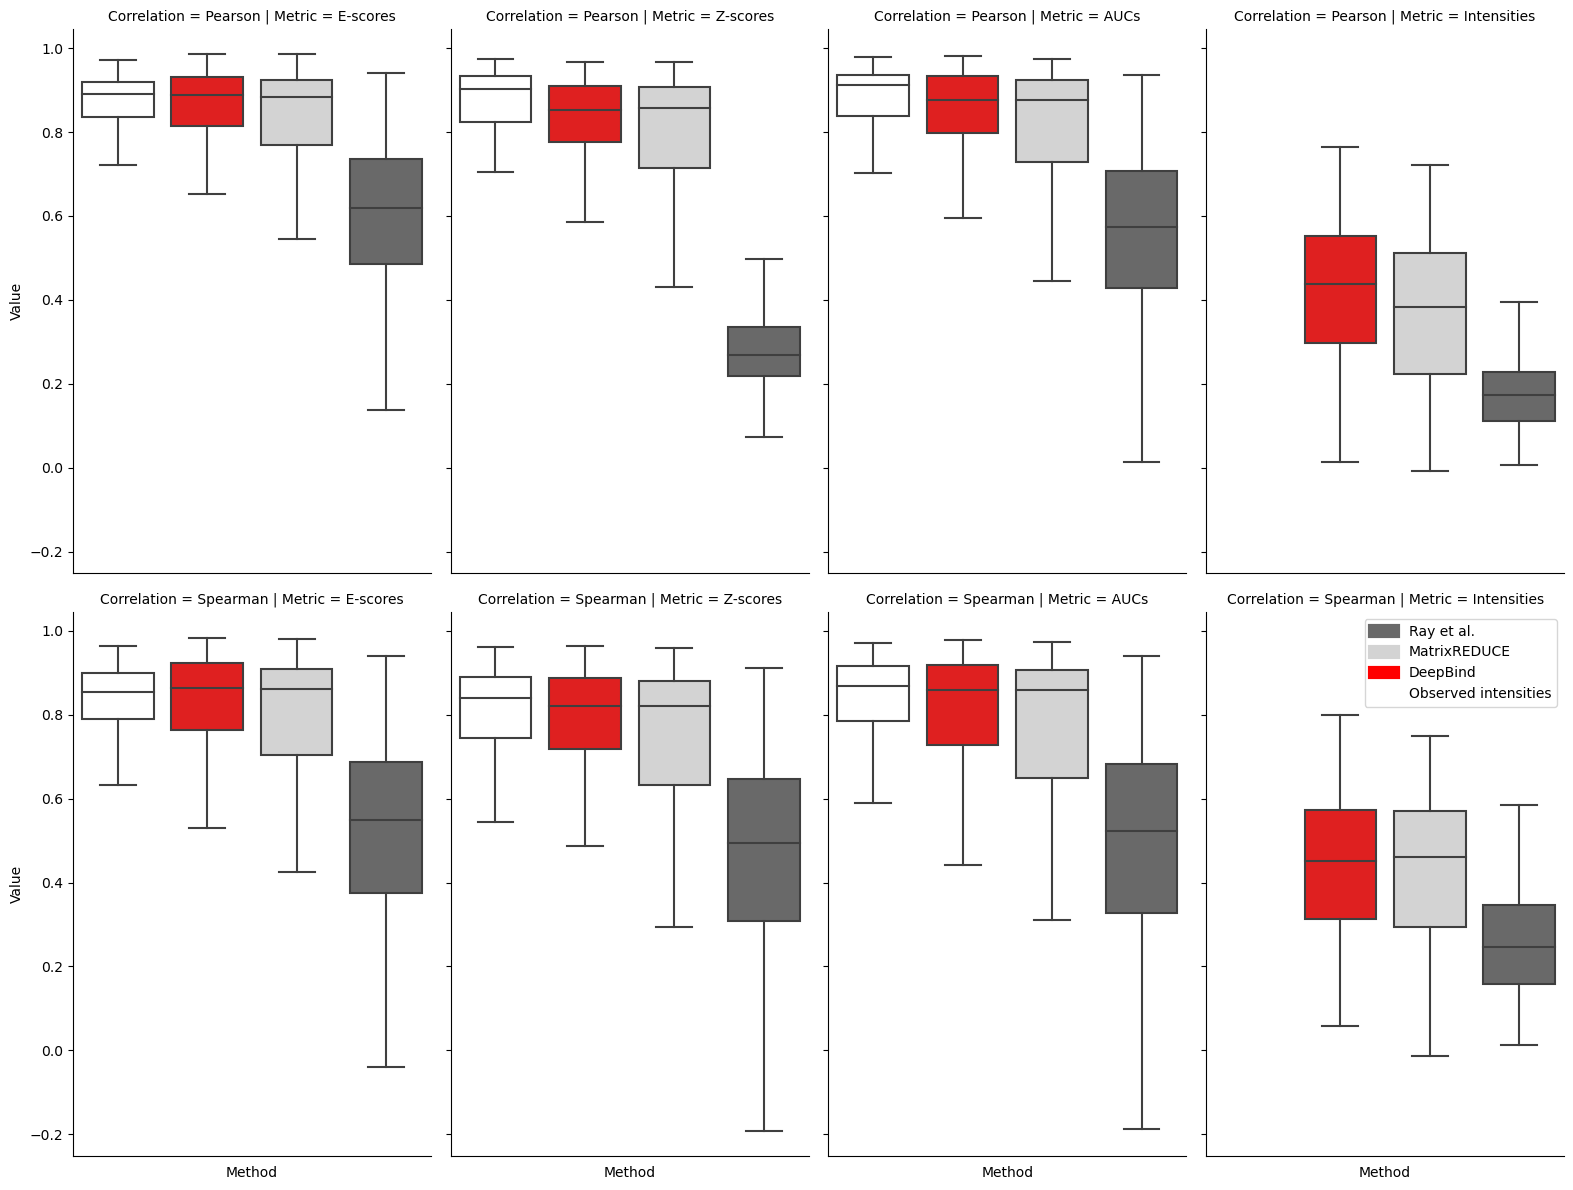

In [100]:
# Plot similar to Supplementary Figure 3 in Alipahani et al
my_pal = {"Ray et al.": "dimgrey", "MatrixREDUCE": "lightgrey", "DeepBind": "red", "Observed intensities": "white"}
order = ["Observed intensities", "DeepBind", "MatrixREDUCE", "Ray et al."]
g = sns.FacetGrid(
    performance_summary, 
    row="Correlation", 
    col="Metric", 
    row_order=["Pearson", "Spearman"], 
    col_order=["E-scores", 
               "Z-scores", 
               "AUCs", 
               "Intensities"],
    height=6,
    aspect=0.66
)
g.map(sns.boxplot, "Method", "Value", palette=my_pal, order=order, showfliers = False)
patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]
plt.legend(handles=patches)
g.set(xticks=[])
g.fig.tight_layout()

# Performances from EUGENe

In [101]:
# Load in the long tables that calculated all 4 metrics for all 244 RBPs (Pearson and Spearman)
n_kmers = 100
pearson_long = pd.DataFrame()
spearman_long = pd.DataFrame()
for method in ["setA", "ST", "MT", "kipoi"]:
    print(f"spearman/pearson_performance_{n_kmers}kmers_{method}.tsv")
    x_pearson = pd.read_csv(os.path.join(settings.output_dir, f"pearson_performance_{n_kmers}kmers_{method}.tsv"), sep="\t")
    pearson_long = pd.concat([pearson_long, x_pearson], axis=0)
    x_spearman = pd.read_csv(os.path.join(settings.output_dir, f"spearman_performance_{n_kmers}kmers_{method}.tsv"), sep="\t")
    spearman_long = pd.concat([spearman_long, x_spearman], axis=0)

spearman/pearson_performance_100kmers_setA.tsv
spearman/pearson_performance_100kmers_ST.tsv
spearman/pearson_performance_100kmers_MT.tsv
spearman/pearson_performance_100kmers_kipoi.tsv


In [102]:
# Convert my performances into the same format as the paper table above
spearman_df = spearman_long.pivot(index=['RBP', 'Metric'], columns='Model', values='Spearman').reset_index()
spearman_df["Correlation"] = "Spearman"
pearson_df = pearson_long.pivot(index=['RBP', 'Metric'], columns='Model', values='Pearson').reset_index()
pearson_df["Correlation"] = "Pearson"
trained_perfromance_df = pd.concat([pearson_df, spearman_df], axis=0)
trained_perfromance_df["Metric"] = trained_perfromance_df["Metric"].replace({"Z-score":"Z-scores", "AUC":"AUCs", "E-score":"E-scores", "Intensity": "Intensities"})
trained_perfromance_df.head()

Model,RBP,Metric,Kipoi,MultiTask,SetA,SingleTask,Correlation
0,RNCMPT00001,AUCs,0.875436,0.777526,0.897752,0.864210,Pearson
1,RNCMPT00001,E-scores,0.849183,0.767820,0.877300,0.861153,Pearson
2,RNCMPT00001,Intensities,0.551630,0.480416,NaN,0.488479,Pearson
3,RNCMPT00001,Z-scores,0.789533,0.768716,0.886684,0.827392,Pearson
4,RNCMPT00002,AUCs,0.750659,0.621898,0.768744,0.477710,Pearson


In [103]:
# Harmonize the paper table
paper_performance_df = performance_df.reset_index().rename({"index": "RBP"}, axis=1)
paper_performance_df.head()

,RBP,Observed intensities,DeepBind,MatrixREDUCE,Ray et al.,Metric,Correlation
0,RNCMPT00001,0.897,0.871,0.892,0.332,E-scores,Pearson
1,RNCMPT00002,0.810,0.761,0.795,0.365,E-scores,Pearson
2,RNCMPT00003,0.908,0.669,0.716,0.741,E-scores,Pearson
3,RNCMPT00004,0.942,0.957,0.959,0.729,E-scores,Pearson
4,RNCMPT00005,0.936,0.940,0.934,0.869,E-scores,Pearson


In [104]:
# Make sure they have the same length
len(paper_performance_df), len(trained_perfromance_df)

(1952, 776)

In [105]:
# Create the aggregated table
full_performance_df = pd.merge(trained_perfromance_df, paper_performance_df, on=["RBP", "Metric", "Correlation"]).set_index("RBP")
full_performance_summary = full_performance_df.melt(id_vars=["Correlation", "Metric"], var_name="Method", value_name="Value")
full_performance_summary["Method"].value_counts()

Kipoi                   776
MultiTask               776
SetA                    776
SingleTask              776
Observed intensities    776
DeepBind                776
MatrixREDUCE            776
Ray et al.              776
Name: Method, dtype: int64

In [106]:
# Save the full table results for supplement
full_performance_df.to_csv(os.path.join(settings.output_dir, "full_performance_df.tsv"), sep="\t", index=True)

# Performance boxplot

/tmp/ipykernel_1882955/3693152122.py:17: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]


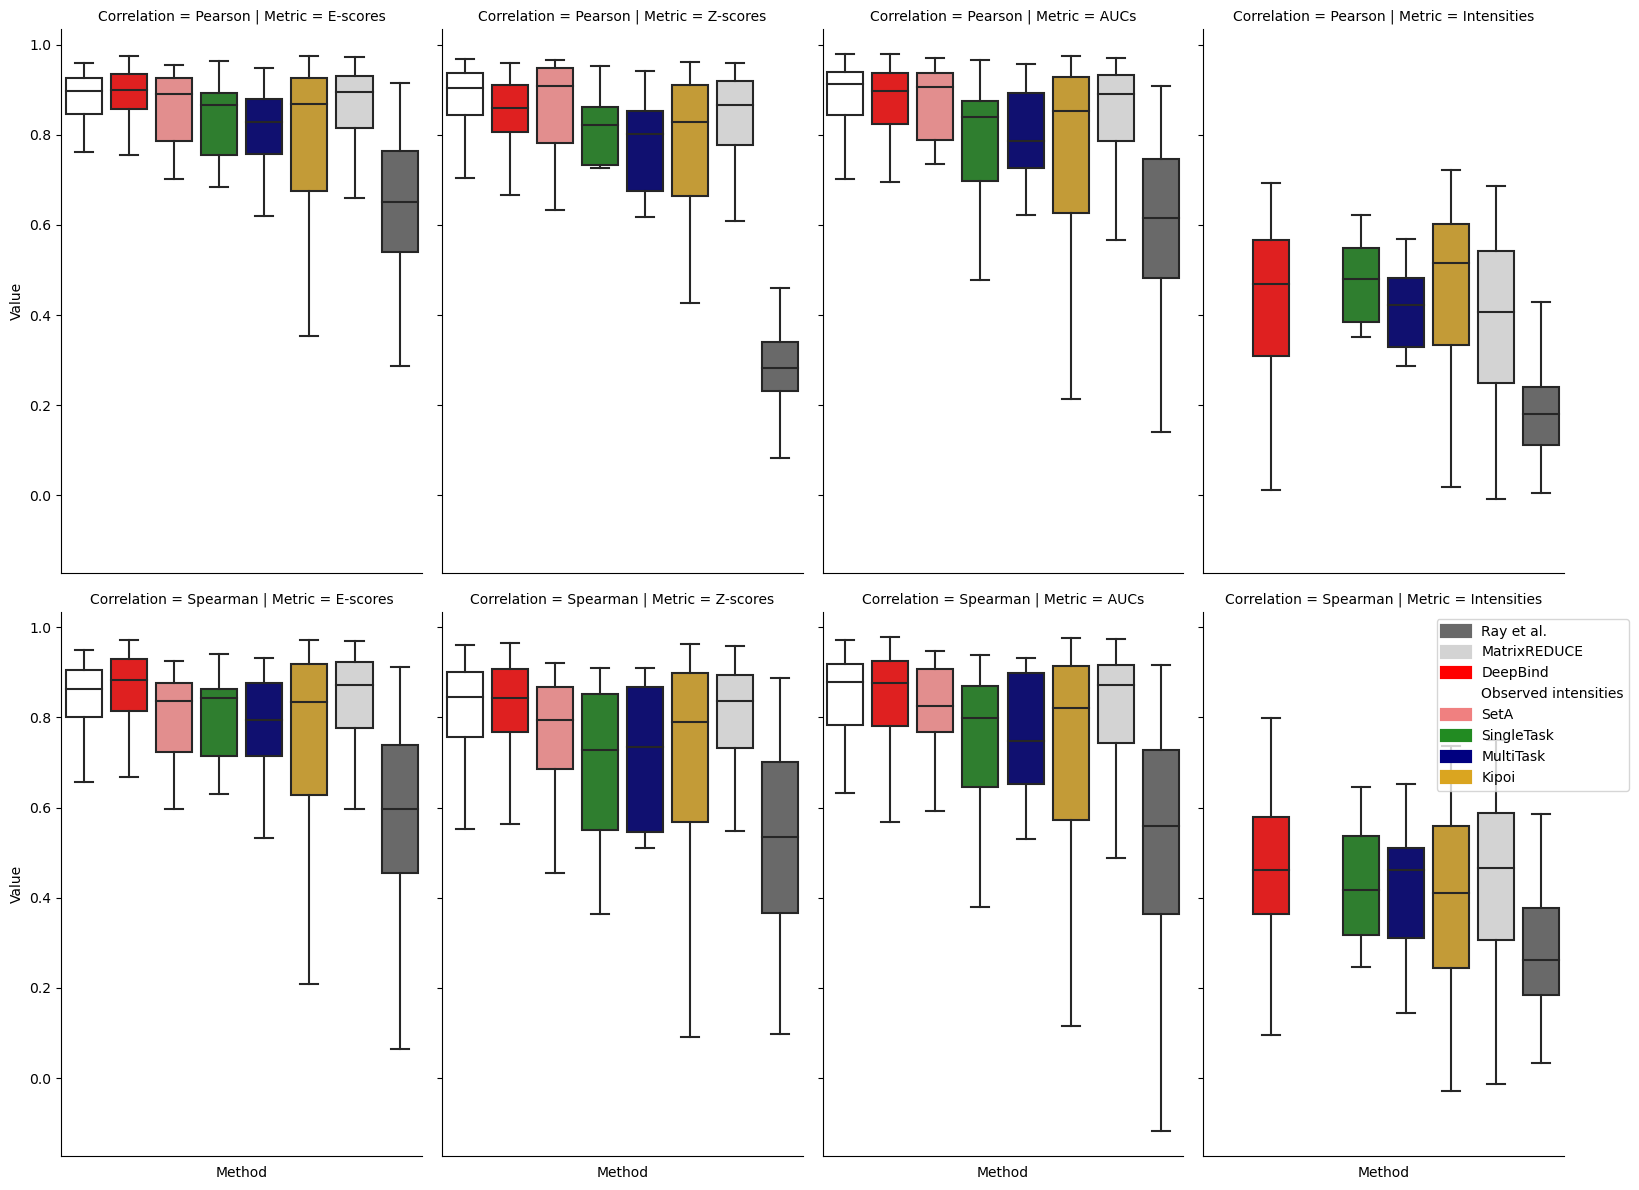

In [107]:
my_pal = {"Ray et al.": "dimgrey", "MatrixREDUCE": "lightgrey", "DeepBind": "red", "Observed intensities": "white",
         "SetA": "lightcoral", "SingleTask": "forestgreen", "MultiTask": "navy", "Kipoi": "goldenrod"}
order = ["Observed intensities", "DeepBind", "SetA", "SingleTask", "MultiTask", "Kipoi", "MatrixREDUCE", "Ray et al."]
g = sns.FacetGrid(
    full_performance_summary, 
    row="Correlation", 
    col="Metric", 
    row_order=["Pearson", "Spearman"], 
    col_order=["E-scores", 
               "Z-scores", 
               "AUCs", 
               "Intensities"],
    height=6,
    aspect=0.66
)
g.map(sns.boxplot, "Method", "Value", palette=my_pal, order=order, showfliers = False)
patches = [matplotlib.patches.Patch(color=v, label=k, edgecolor="k", linewidth=3) for k,v in my_pal.items()]
g.set(xticks=[])
g.fig.tight_layout()
plt.legend(handles=patches, loc='upper right', bbox_to_anchor=(1.2, 1))
plt.savefig(os.path.join(settings.figure_dir, f"correlation_boxplots_{n_kmers}kmers_all.pdf"), dpi=300)

# Comparison scatterplots

In [108]:
# Helper function to plot the a line to apply to FacetGrid
def const_line(*args, **kwargs):
    x = np.arange(0, 1.01, 0.01)
    plt.plot(x, x, c='dimgrey', ls='--')

In [110]:
import itertools
order = ["SingleTask", "MultiTask", "SetA", "Kipoi", "Observed intensities", "DeepBind",  "MatrixREDUCE", "Ray et al."]
if not os.path.exists(os.path.join(settings.figure_dir, "scatterplot_comparisons")):
    os.makedirs(os.path.join(settings.figure_dir, "scatterplot_comparisons"))
for method_x, method_y in list(itertools.combinations(order, 2)):
    g = sns.FacetGrid(full_performance_df, col="Metric", col_order=["Z-scores", "AUCs", "E-scores", "Intensities"])
    g.map(sns.scatterplot, method_x, method_y, s=10, color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
    g.map(const_line)
    method_x_save = method_x.replace(" ", "-").split(".")[0]
    method_y_save = method_y.replace(" ", "-").split(".")[0]
    plt.savefig(os.path.join(settings.figure_dir, "scatterplot_comparisons", f"model_pearson_scatterplot_comparisons_{n_kmers}kmers_{method_x_save}_{method_y_save}.pdf"), dpi=300)
    plt.close()

# Best model intensity correlations

In [ ]:
# Grab these for generating interpetations on a subset
intensity_df = trained_perfromance_df[trained_perfromance_df["Metric"] == "Intensities"].set_index("RBP")
intensity_df["SingleTask"].sort_values(ascending=False)[:10].to_csv(os.path.join(settings.output_dir, "top_10_ST_intensities.tsv"), sep="\t")
intensity_df["MultiTask"].sort_values(ascending=False)[:10].to_csv(os.path.join(settings.output_dir, "top_10_MT_intensities.tsv"), sep="\t")

# TomTom Results

In [ ]:
# Get the signficant single task filter annotations for a given RBP
rbp = "RNCMPT00238"
single_res = pd.read_csv(os.path.join(eu.settings.output_dir, f"{rbp}_filters_0.75_ST_tomtom.tsv"), sep="\t", index_col=0)
single_res_sig = single_res[single_res["q-value"] < 0.05].sort_values("q-value")
single_res_sig[single_res_sig["Target_ID"] == rbp]

In [ ]:
# Get signficant single task filter annotations and print for given RBP
multi_res = pd.read_csv(os.path.join(eu.settings.output_dir, "filters_0.75_MT_tomtom.tsv"), sep="\t", comment="#")
multi_res_sig = multi_res[multi_res["q-value"] < 0.05].sort_values("q-value")
multi_res_sig[multi_res_sig["Target_ID"] == "RNCMPT00238"]

In [ ]:
# Create a dataframe that relates performance to number of annotated filters assigned to that RBP
intensity_df = trained_perfromance_df[trained_perfromance_df["Correlation"] == "Pearson"].reset_index()
intensity_df = intensity_df[intensity_df ["Metric"] == "Z-scores"].reset_index()
mt_intensity = intensity_df.set_index("RBP")["MultiTask"]
filter_val_counts = pd.DataFrame(multi_res_sig.value_counts("Target_ID")).astype(int)
filter_val_counts.columns = ["num_sig_filters"]
df = pd.concat([mt_intensity, filter_val_counts], axis=1).dropna()

In [ ]:
# Plot this relationship and output a correlation
fig, ax = plt.subplots(figsize=(5, 2))
sns.stripplot(data=df, x="num_sig_filters", y="MultiTask", color="royalblue", alpha=0.75, edgecolor="k", linewidth=0.3)
plt.savefig(os.path.join(eu.settings.figure_dir, "num_sig_filters_vs_MT_intensity.pdf"), dpi=300)
spearmanr(df["MultiTask"], df["num_sig_filters"])

In [ ]:
# Generate a merged TomTom results df for the supplement
merged_df = pd.DataFrame()
for file in sorted(glob.glob(os.path.join(eu.settings.output_dir, "*0.75*_tomtom.tsv"))):
    name = file.split("/")[-1].split("_")[0]
    if name == "filters":
        name = "multitask"
    x["model"] = name
    x = pd.read_csv(file, comment="#", sep="\t")
    merged_df = pd.concat([merged_df, x])
merged_df.to_csv(os.path.join(eu.settings.output_dir, "all_0.75_tomtom.tsv"), index=False, sep="\t")

# Filter viz

In [ ]:
# Load in the PFMs in a SeqData
sdata_test = eu.dl.read_h5sd(os.path.join(eu.settings.output_dir, "norm_test_predictions_and_intepretations_noMTfilters_0.75.h5sd"))

In [ ]:
eu.pl.multifilter_viz(
    sdata_test,
    filter_ids=range(0,32),
    uns_key=f"pfms_{rbp}_ST",
    titles=[f"filter {i}" for i in range(32)],
    vocab="RNA",
    num_rows=8,
    num_cols=4,
    save=os.path.join(eu.settings.figure_dir, "filter_viz", f"filters_viz_{rbp}_0.75_ST.pdf")
)


---